In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from functions import Rossler, Solution, jacobian, plot
from ae import Autoencoder

In [2]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =[0,1,0]
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
tau = 17

In [3]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)
v3 = np.array(xs[2*tau: n]) #x(t + 2τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])
dv3 = np.gradient(v3, t[:len(v1)])

In [4]:
torch.manual_seed(123)

In [5]:
x_true = torch.tensor(np.array([xs[:len(v1)], ys[:len(v1)], zs[:len(v1)]]), dtype=torch.float32).T
v = torch.tensor(np.array([v1, v2, v3]), dtype=torch.float32, requires_grad=True).T

input_dim = 3
latent_dim = 3
autoencoder = Autoencoder(17, x_true = x_true, Supervised= True,  l={'l1': 0, 'l2': 0, 'l3': 0, 'l4': 0, 'l5': 0, 'l6': 0})
learning_rate = 1e-3
num_epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [6]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    Loss = autoencoder.loss(v, 0, criterion)
    Loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Loss.item():.4f}')

Epoch [100/1000], Loss: 3.0248
Epoch [200/1000], Loss: 2.2559
Epoch [300/1000], Loss: 1.4670
Epoch [400/1000], Loss: 0.7507
Epoch [500/1000], Loss: 0.3720
Epoch [600/1000], Loss: 0.2550
Epoch [700/1000], Loss: 0.1979
Epoch [800/1000], Loss: 0.1583
Epoch [900/1000], Loss: 0.1297
Epoch [1000/1000], Loss: 0.1084


In [7]:
autoencoder.eval() 
latent_variables = autoencoder.encode(v) 

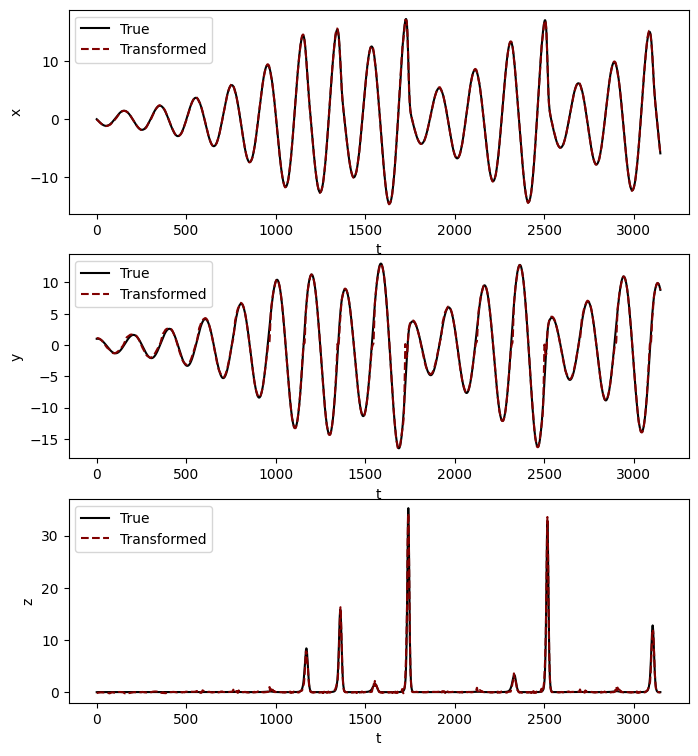

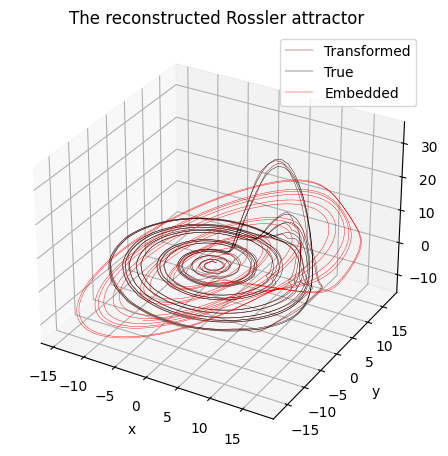

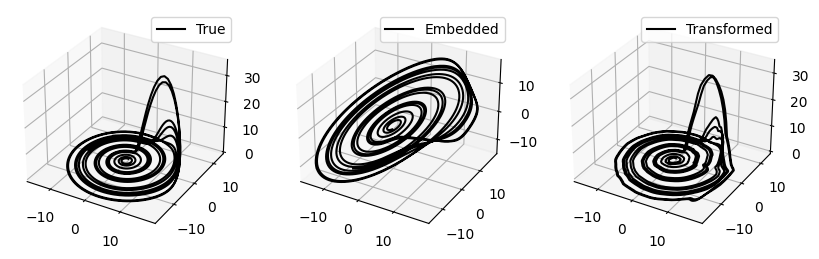

In [18]:
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()
z_ae = latent_variables[:,2].detach().numpy()

plot(xs, ys, zs, v1, v2, v3, x_ae, y_ae, z_ae)

In [9]:
t_ae = t[:len(x_ae)]

dx = np.gradient(x_ae, t_ae)
dy = np.gradient(y_ae, t_ae)
dz = np.gradient(z_ae, t_ae)

output = np.array([dx, dy, dz])
input = np.array([np.ones(len(x_ae)), x_ae, y_ae, z_ae, x_ae**2, y_ae**2, z_ae**2, x_ae*y_ae, x_ae*z_ae, z_ae*y_ae]).T

out_train, out_test, in_train, in_test = train_test_split(output[:, :input.shape[0]].T, input, test_size=0.2, random_state=0, shuffle=False)

In [10]:
model = Lasso(alpha=1e-4, max_iter= 1500000, fit_intercept=False)
model.fit(in_train, out_train)
score = model.score(in_test, out_test)
coef = model.coef_
print("Score:", score)

Score: 0.9358981975274275


In [11]:
library_names = ['*1', '*x', '*y', '*z', '*x**2', '*y**2', '*z**2', '*x*y', '*x*z', '*y*z']
var_names = ['x', 'y', 'z'] 
for i in range(len(var_names)):
    eqn = [f'{var_names[i]}_dot = ']
    for j in range(coef.shape[1]):
        if np.abs(coef[i, j]) > 0.09:
            eqn.append(f'+ {coef[i, j]} {library_names[j]} ')
    print(''.join(eqn))

x_dot = + -1.0008651096810746 *y + -0.7686927030881341 *z 
y_dot = + 1.02976566739883 *x + 0.15194696645575623 *y + -1.0182013439243975 *z + 0.12396993675120352 *y*z 
z_dot = + -9.826161391073095 *z + 0.9400452940367973 *x*z 


In [12]:
def equs(X,t,P):
    x,y,z = X
    x_dot = -0.9927656408221328 *y + -1.1200495485111128 *z
    y_dot =  0.9963052742737867 *x + 0.14572679908902264 *y 
    z_dot = 0.19970639564173506 + -10.408804799230507 *z + 1.0024607983397082 *x*z 
    return x_dot, y_dot, z_dot
x_sin, y_sin, z_sin = Solution(equs, x0, t_ae, 0)

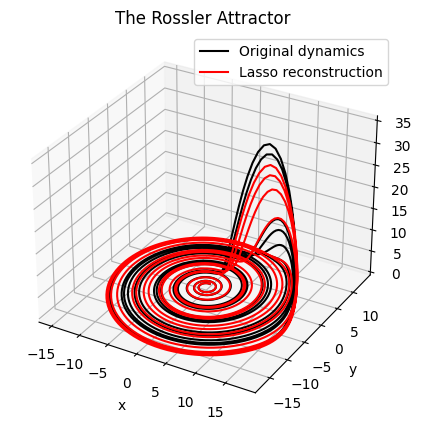

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(xs[:len(x_sin)], ys[:len(x_sin)],zs[:len(x_sin)],color = 'k', label = "Original dynamics")
ax.plot(x_sin, y_sin,z_sin,color = 'r', label = "Lasso reconstruction")
ax.set_title("The Rossler Attractor")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("z")
plt.legend()
plt.show()

In [14]:
X = np.array([x_ae, y_ae, z_ae]).T
print(X.shape)

diff_method = ps.FiniteDifference(order = 1)
feature_library = ps.PolynomialLibrary(degree = 2)
optimizer = ps.STLSQ(threshold=0.05)

model = ps.SINDy(
    differentiation_method=diff_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["*x", "*y", "*z"],
)

model.fit(X, t_ae)
model.print()

(3150, 3)
(*x)' = -0.997 *y + -1.021 *z
(*y)' = 0.993 *x + 0.120 *y + -0.132 *z + 0.058 *y *z
(*z)' = 0.104 1 + -9.743 *z + 0.950 *x *z


In [15]:
def SINDy_equs(X, t, P):
    x, y, z = X
    dx = -0.993 *y + -0.984 *z
    dy = 1.003 *x + 0.134 *y
    dz = 0.500 + -10.241 *z + 0.995 *x *z
    return dx, dy, dz

x_si, y_si, z_si = Solution(SINDy_equs, [x_ae[0], y_ae[0], z_ae[0]], t_ae, [0,0,0])

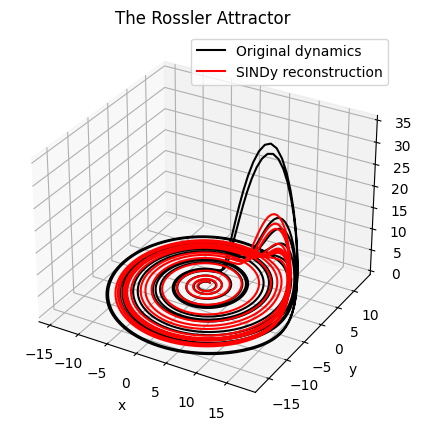

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(xs[:len(x_si)], ys[:len(x_si)],zs[:len(x_si)],color = 'k', label = "Original dynamics")
ax.plot(x_si, y_si, z_si,color = 'r', label = "SINDy reconstruction")
ax.set_title("The Rossler Attractor")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("z")
plt.legend()
plt.show()